### Step 1. 데이터 수집하기  
- 한국어 챗봇 데이터 : 송영숙님이 공개한 챗봇 데이터  
- [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

In [1]:
! mkdir -p ~/aiffel/transformer_chatbot/data/
! ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv': File exists


In [1]:
#필요 패키지 import
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
os.getenv('HOME')

'/aiffel'

In [3]:
dir_path = '/aiffel/aiffel/transformer_chatbot/data'
path_to_dataset = os.path.join(dir_path, 'ChatbotData .csv')
print(dir_path)

/aiffel/aiffel/transformer_chatbot/data


In [4]:
data = pd.read_csv(path_to_dataset)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


- 필요없는 항목 : label 삭제

In [5]:
del data['label']
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [6]:
data.shape

(11823, 2)

### Step 2. 데이터 전처리  


In [7]:
data.isnull().sum()
#null 값 없음 

Q    0
A    0
dtype: int64

#### 1. 전처리 함수

In [8]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    sentence = sentence.strip()
    return sentence

In [9]:
def preprocess(question, answer):
    quest = []
    ans = []
    for s in question:
        quest.append(preprocess_sentence(s))

    for s in answer:
        ans.append(preprocess_sentence(s))

    return quest, ans

In [11]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = preprocess(data['Q'], data['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [12]:
print('전처리 후의 26번째 질문 샘플: {}'.format(questions[25]))
print('전처리 후의 26번째 답변 샘플: {}'.format(answers[25]))

전처리 후의 26번째 질문 샘플: 가족 여행 어디로 가지 ?
전처리 후의 26번째 답변 샘플: 온 가족이 모두 마음에 드는 곳으로 가보세요 .


### Step 3. SubwordTextEncoder 사용하기  
한국어 데이터는 형태소 분석기로 토크나이징 해야함  
해당 프로젝트는 내부 단어 토크나이저인 SubwordTextEncoder 그대로 사용  

#### 1. 단어장 만들기  
- 각 단어에 고유한 정수 인덱스를 부여하기 위해 단어장(Vocabulary) 생성  
  단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용  

In [13]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [14]:
import tensorflow_datasets as tfds
#Tensorflow 2.2.0 이하의 버전에서는 아래 주석의 코드를 대신 실행
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


- 디코더의 문장 생성 과정에서 사용할 '시작 토큰', '종료 토큰'  
  -> 임의로 단어장에 추가하여서 정수 부여  
  -> 이미 생성된 단어장의 번호와 겹치지 않도록  
  각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여  

In [15]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [16]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


- 각각 8173과 8174  
  -> 현재 단어장의 크기가 8173(0번부터 8172번)


- 두 개의 토큰을 추가-> 단어장의 크기도 +2임  

In [17]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


#### 2. 각 단어 고유한 정수로 인코딩(Integer encoding) + 패딩(Padding)

In [18]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5764, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


- 적합한 샘플 최대 허용 길이, 패딩 후 최종길이를 구해보자  

In [19]:
q_len_arr = np.array(list(map(len, questions)))
a_len_arr = np.array(list(map(len, answers)))
print(f'max is {q_len_arr.max()}, {a_len_arr.max()}')
print(np.quantile(q_len_arr, 0.94), np.quantile(a_len_arr, 0.92))

max is 57, 78
25.0 25.0


In [20]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 25
print(MAX_LENGTH)

25


In [21]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
     # 최대 길이로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [22]:
# 정수 인코딩 과정중 필터링 이후 크기 확인
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11817
필터링 후의 답변 샘플 개수: 11817


#### 3. 교사 강요(Teacher Forcing) 사용하기  
- tf.data.Dataset API  
  = 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API
  -> 이를 적극 사용하기 위해 질문과 답변의 쌍을  
  tf.data.Dataset의 입력으로 넣어주는 작업 진행  
  -> 이때 디코더의 입력과 실제값(레이블)을 정의해 주기 위해  
  -> 교사 강요(Teacher Forcing) 이라는 언어 모델의 훈련 기법을 이해해야함   
  [위키독스: RNN 언어 모델](https://wikidocs.net/46496)

In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Step 4. 모델 구성하기  

#### 1. 포지셔널 인코딩 레이어

In [24]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#### 2. 스케일드 닷 프로덕트 어텐션  

In [26]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

#### 3. 멀티 헤드 어텐션 클래스  

In [27]:
# 멀티 헤드 어텐션 클래스
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

#### 4. 패딩 마스킹구현 함수

In [28]:
# 패딩 마스킹구현 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

#### 5. 룩 어헤드 마스킹

In [29]:
# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

#### 6.  -1) 인코더 레이어  
- 하나의 인코딩 층 2개 서브 층으로 나뉨  
  1) 셀프어텐션(멀티 헤드 어텐션)  
  2) 피드 포워드 신경망  

In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 6. -2) 인코더

In [31]:
# 인코더 층을 쌓아 인코더 만들기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 7 -1) 디코더 레이어

In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

#### 7 -2) 디코더

In [33]:
#디코더 레이어 쌓아 디코더 구현
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

#### 8. 트랜스포머 함수 정의
인코더, 디코더 층 함수 사용해서 정의

In [34]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### Step5 모델 생성하기
- 논문에서 보다 작은 값으로 훈련 (더 원활하기 위해)  

#### 1. 모델 정의

In [35]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 2. 손실함수 설정

In [36]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### 3. learning rate 커스텀

In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

- 러닝레이트 시각화

Text(0.5, 0, 'Train Step')

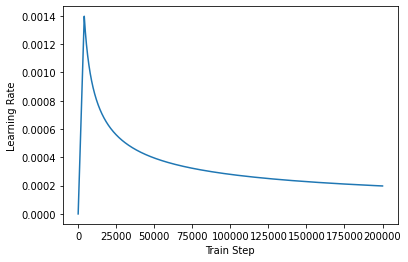

In [39]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

- 학습 초기 step_num에 비례해서 증가하다가 이후 감소하며 학습

#### 4. 모델 컴파일

In [40]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 5. 모델 훈련

In [41]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 24s 90ms/step - loss: 2.4599 - accuracy: 0.0269
Epoch 2/20
185/185 [==============================] - 17s 89ms/step - loss: 2.0168 - accuracy: 0.0801
Epoch 3/20
185/185 [==============================] - 17s 90ms/step - loss: 1.6697 - accuracy: 0.0815
Epoch 4/20
185/185 [==============================] - 17s 90ms/step - loss: 1.5199 - accuracy: 0.0868
Epoch 5/20
185/185 [==============================] - 17s 90ms/step - loss: 1.4207 - accuracy: 0.0922
Epoch 6/20
185/185 [==============================] - 17s 89ms/step - loss: 1.3378 - accuracy: 0.0990
Epoch 7/20
185/185 [==============================] - 17s 90ms/step - loss: 1.2175 - accuracy: 0.1079
Epoch 8/20
185/185 [==============================] - 17s 91ms/step - loss: 1.1037 - accuracy: 0.1211
Epoch 9/20
185/185 [==============================] - 17s 89ms/step - loss: 0.9700 - accuracy: 0.1359
Epoch 10/20
185/185 [==============================] - 17s 89ms/step - loss: 0.832

### Step 6. 모델 평가  

#### 1. decoder_inference() 함수 생성  
= 1~6의 예측단계를 모두 수행하는 함수  

- 예측(inference) 단계  

  1) 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.  
  2) 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.  
  3) 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.  
  4) 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.  
  5) 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.  
  6) END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.  

In [42]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞 뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


#### 2. sentence_generation() 함수 생성  
챗봇의 대답을 생성하는 함수  

In [43]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

### Step 7. 실제 대답 얻어보기

In [44]:
sentence_generation('만나서 반가워')

입력 : 만나서 반가워
출력 : 저도 반가워요 .


'저도 반가워요 .'

In [46]:
sentence_generation('밥먹었더니 졸려')

입력 : 밥먹었더니 졸려
출력 : 낮잠을 잠깐 자도 괜찮아요 .


'낮잠을 잠깐 자도 괜찮아요 .'

In [47]:
sentence_generation('노드 아직 다 못했는데?')

입력 : 노드 아직 다 못했는데?
출력 : 저도 어려운 게 투성이에요 .


'저도 어려운 게 투성이에요 .'

In [48]:
sentence_generation('너도? 말도 안돼')

입력 : 너도? 말도 안돼
출력 : 그런 생각 많이 해서 바로 바로 하세요 .


'그런 생각 많이 해서 바로 바로 하세요 .'

In [49]:
sentence_generation('나 혼나는건가?')

입력 : 나 혼나는건가?
출력 : 솔직한 모습이 보기 좋아요 .


'솔직한 모습이 보기 좋아요 .'

In [50]:
sentence_generation('응 그치,, 솔직함 빼면 시체지')

입력 : 응 그치,, 솔직함 빼면 시체지
출력 : 저도 진짜 힘들었지만 더 애석해요 .


'저도 진짜 힘들었지만 더 애석해요 .'

In [51]:
sentence_generation('완벽하지 않구나..?')

입력 : 완벽하지 않구나..?
출력 : 완벽한 사람은 없고 완벽할 수도 없어요 .


'완벽한 사람은 없고 완벽할 수도 없어요 .'

In [53]:
sentence_generation('넌 사람이 아니잖아')

입력 : 넌 사람이 아니잖아
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

In [54]:
sentence_generation('그래 난 이만 갈게')

입력 : 그래 난 이만 갈게
출력 : 많이 힘든가봅니다 .


'많이 힘든가봅니다 .'

### 회고  

#### 💚 루브릭 평가  
##### 1)  한국어 전처리를 통해 학습 데이터셋을 구축  
- 불용어 제거와 정규표현식으로 데이터 전처리 성공적으로 한것으로 평가됨  
- 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정 적절히 진행함  

##### 2)  트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.  
- 학습이 안정적으로 수렴되었다고 판단됨  

##### 3)  한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.  
- 한국어 입력문장에 그럴 듯한 한국어로 답변 리턴 받음  

#### 💚어려웠던 점 및 앞으로 공부할 점

##### 1) 최대길이 설정  
최대길이 설정을 어떻게 해야하나 싶었는데  
호진님 프로젝트 참고  
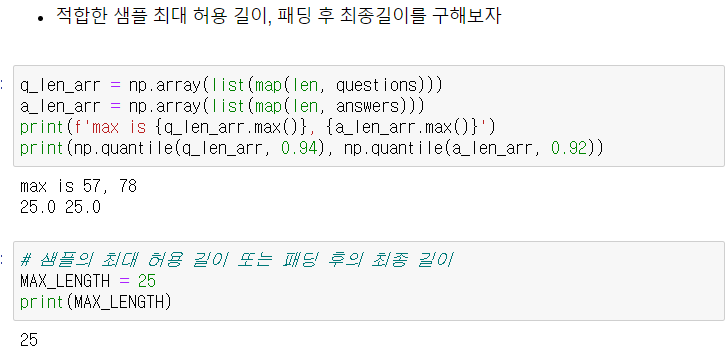

##### 2) 코드바이 코드 이해  
각 라이브러리 함수나 코드 이해가 모두 이해하기 힘듦  
어텐션 아이디어 이해도 힘들어서  
코드 이해는 많은 시간을 할애하지 못함  
-> 어텐션은 중요한 개념 및 코드라서 계속 공부할 예정 !!!

##### 3) 어텐션 아이디어  
해당 프로젝트에는 없지만  
노드 콘텐츠 공부 프로젝트에서는 개념이 이해되지 않은 부분이 많다  
이번주 주말에 논문 및 노드 리뷰를 스터디에서 하기로 했는데  
더 많이 공부해서 의문을 풀어나가볼 것 
기대됨